# Investigating Machine Learning Models Performance for Meterological Interpolation
### Eli Simic Robertson
### Sentient Hubs Internship Short Project

In [279]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from tftimeseries import *

import sys, os
sys.path.append(os.path.abspath(os.path.join('..', 'MastersDissertation', 'nbs', 'glassnode')))

RESPONSE_VAR = 'temperature'

%matplotlib inline

In [249]:
df_temp = pd.read_csv('./hourly_weather_kaggle/temperature.csv')
df_humid = pd.read_csv('./hourly_weather_kaggle/humidity.csv')
df_press = pd.read_csv('./hourly_weather_kaggle/pressure.csv')
df_wind_d = pd.read_csv('./hourly_weather_kaggle/wind_direction.csv')
df_wind_s = pd.read_csv('./hourly_weather_kaggle/wind_speed.csv')

# Make dataframe for all Los Angeles weather continuous data features
df = df_temp[['datetime', 'Los Angeles']].rename(columns={'Los Angeles': 'temperature'})

df = df.merge(df_humid[['datetime','Los Angeles']].rename(columns={'Los Angeles': 'humidity'}))
df = df.merge(df_press[['datetime','Los Angeles']].rename(columns={'Los Angeles': 'pressure'}))
df = df.merge(df_wind_d[['datetime','Los Angeles']].rename(columns={'Los Angeles': 'wind_d'}))
df = df.merge(df_wind_s[['datetime','Los Angeles']].rename(columns={'Los Angeles': 'wind_s'}))


df['datetime'] = pd.to_datetime(df['datetime'])

df.head(5)

,datetime,temperature,humidity,pressure,wind_d,wind_s
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN
1,2012-10-01 13:00:00,291.870000,88.0,1013.0,0.0,0.0
2,2012-10-01 14:00:00,291.868186,88.0,1013.0,0.0,0.0
3,2012-10-01 15:00:00,291.862844,88.0,1013.0,0.0,0.0
4,2012-10-01 16:00:00,291.857503,88.0,1013.0,0.0,0.0


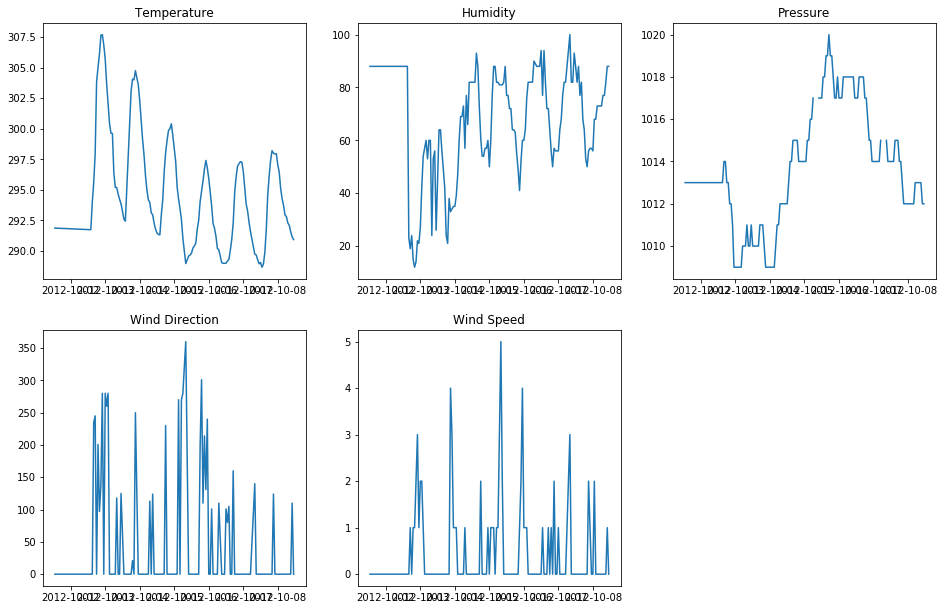

In [250]:
week = 24 * 7
df_1w = df.iloc[:week, :]

plt.figure(figsize=(16, 16))
plt.subplot(331)
plt.plot(df_1w['datetime'], df_1w['temperature'])
plt.title('Temperature')
plt.subplot(332)
plt.plot(df_1w['datetime'], df_1w['humidity'])
plt.title('Humidity')
plt.subplot(333)
plt.plot(df_1w['datetime'], df_1w['pressure'])
plt.title('Pressure')
plt.subplot(334)
plt.plot(df_1w['datetime'], df_1w['wind_d'])
plt.title('Wind Direction')
plt.subplot(335)
plt.plot(df_1w['datetime'], df_1w['wind_s'])
plt.title('Wind Speed');

In [251]:
df.isna().sum()

datetime         0
temperature      3
humidity       152
pressure       252
wind_d           1
wind_s           1
dtype: int64

In [252]:
252 / df.shape[0]

0.0055686915784588864

In [253]:
df = df.interpolate(method='linear').dropna()
df.isna().sum().sum()

0

#### Methodology 
- Create artificially noisy dataset
- Benchmark conventional interpolation techniques
- Train various Machine Learning models on Weather data to predict **Temperature**.
- Compare Model Predictions with Test dataset.
- Benchmark ML models performances against conventional interpolation techniques.

## Create Artificially Noisy Dataset
- Create 10% missing temperature data.

In [293]:
train_df, val_df, test_df = split_df(df)

noisy_test_df = test_df.copy()

In [294]:
noisy_test_df['temperature'].isna().sum()

0

In [295]:
noise_level = 0.2
n_gaps = int(noisy_test_df.shape[0] * noise_level)
# randomly choose gap indexes
gap_indxs = np.random.choice(a=noisy_test_df.shape[0], size=n_gaps, replace=False)

In [296]:
noisy_test_df['temperature'].iloc[gap_indxs] = np.nan

/home/franticoreo/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [297]:
noisy_test_df['temperature'].isna().sum()

905

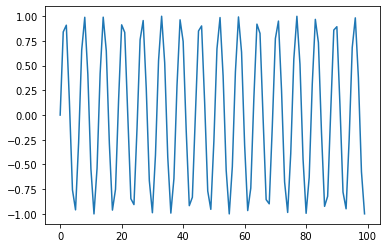

In [310]:
# plt.plot(np.arange(noisy_test_df.shape[0]), np.sin(np.arange(noisy_test_df.shape[0])))

plt.plot(np.arange(100), )

In [317]:
sum_x

4950

In [316]:
x = np.arange(100)

sum_x = np.sum(x)

np.sin(x) / sum_x

array([ 0.00000000e+00,  1.69994138e-04,  1.83696450e-04,  2.85090925e-05,
       -1.52889393e-04, -1.93722076e-04, -5.64475754e-05,  1.32724565e-04,
        1.99870353e-04,  8.32562596e-05, -1.09903255e-04, -2.02018224e-04,
       -1.08398569e-04,  8.48822297e-05,  2.00122698e-04,  1.31371281e-04,
       -5.81622862e-05, -1.94221716e-04, -1.51714595e-04,  3.02782242e-05,
        1.84433384e-04,  1.69021341e-04, -1.78814329e-06, -1.70953617e-04,
       -1.82945124e-04, -2.67377273e-05,  1.54052212e-04,  1.93207258e-04,
        5.47284421e-05, -1.34067451e-04, -1.99602348e-04, -8.16237667e-05,
        1.11399330e-04,  2.02002396e-04,  1.06885391e-04, -8.65015494e-05,
       -2.00359364e-04, -1.30007704e-04,  5.98724401e-05,  1.94706139e-04,
        1.50527911e-04, -3.20449836e-05, -1.85155868e-04, -1.68035302e-04,
        3.57614649e-06,  1.71899702e-04,  1.82179464e-04,  2.49642672e-05,
       -1.55202962e-04, -1.92677304e-04, -5.30050210e-05,  1.35399834e-04,
        1.99318705e-04,  

In [302]:
methods = ['linear', 'index', 'pad', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic', 'spline',
           'polynomial', 'piecewise_polynomial', 'spline', 'pchip', 'akima',
      'cubicspline', 'from_derivatives']

mses = []

for method in methods:
    print(method)
    order = 2
    temp_int = noisy_test_df['temperature'].interpolate(method=method, order=order)
    # fill if method creates NA val
    temp_int = temp_int.fillna(method='bfill')
    mse = mean_squared_error(test_df['temperature'], temp_int)

    mses.append(mse)

linear
index
pad
nearest
zero
slinear
quadratic
cubic
spline
polynomial
piecewise_polynomial
spline
pchip
akima
cubicspline
from_derivatives


In [303]:
pd.DataFrame({"method": methods, "MSE": mses}).sort_values(by='MSE', ascending=True)

,method,MSE
13,akima,0.030353
12,pchip,0.030481
6,quadratic,0.036380
9,polynomial,0.036380
7,cubic,0.037841
14,cubicspline,0.037841
10,piecewise_polynomial,0.043240
15,from_derivatives,0.043240
0,linear,0.043240
1,index,0.043240


## Linear Model

In [ ]:
train_df, val_df, noisy_test_df = split_df(df)

# num_features = df.shape[1]
train_df, val_df, noisy_test_df, scaler = scale_datasets(train_df, val_df,
                                                   noisy_test_df, dependent=RESPONSE_VAR)